In [356]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### 1. Base Layer class

In [357]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

### 2. Activation Functions class

In [358]:
class Activation(Layer):
    def __init__(self, activation: str = "relu"):
        self.activation = activation

    def tanh(sefl, x):
        return np.tanh(x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return np.maximum(0, x)

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def get_activation(self, X):
        if self.activation == "tanh":
            return self.tanh(X)
        elif self.activation == "sigmoid":
            return self.sigmoid(X)
        elif self.activation == "relu":
            return self.relu(X)
        else:
            raise ValueError("Invalid activation function")

    def get_d_activation(self, dZ):
        if self.activation == "tanh":
            return self.d_tanh(dZ)
        elif self.activation == "sigmoid":
            return self.d_sigmoid(dZ)
        elif self.activation == "relu":
            return self.d_relu(dZ)
        else:
            raise ValueError("Invalid activation function")

    def forward(self, X):
        self.X = X
        return self.get_activation(self.X)

    def backward(self, dZ, learning_rate):
        return np.multiply(dZ, self.get_d_activation(self.X))

### 3. Dense Layer class

In [359]:
class Dense(Layer):
    def __init__(self, input_size: int, output_size: int) -> None:
        """
        :param input_size: size of input vector
        :param output_size: size of output vector
        """
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        :param input: input vector
        """
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        """
        :param dZ: gradient of loss with respect to output
        :param lr: learning rate
        """
        dW = np.dot(dZ, self.input.T)
        dX = np.dot(self.weights.T, dZ)
        self.weights -= lr * dW
        self.bias -= lr * dZ
        return dX

### 4. Loss Functions class

In [360]:
class Loss:
    def __init__(
        self, loss: str = "mse", y_true: np.ndarray = None, y_pred: np.ndarray = None
    ) -> None:
        """
        :param loss: str, loss function (Available: mse, bce)
        :param y_true: np.ndarray, true values
        :param y_pred: np.ndarray, predicted values
        """
        self.loss = loss
        self.y_true = y_true
        self.y_pred = y_pred

    # Mean Squared Error
    def mse(self) -> float:
        return np.mean(np.power(self.y_true - self.y_pred, 2))

    def d_mse(self) -> float:
        return 2 * (self.y_pred - self.y_true) / np.size(self.y_true)

    # Binary Cross Entropy
    def bce(self) -> float:
        return np.mean(
            -self.y_true * np.log(self.y_pred)
            - (1 - self.y_true) * np.log(1 - self.y_pred)
        )

    def d_bce(self) -> float:
        return (
            (1 - self.y_true) / (1 - self.y_pred) - self.y_true / self.y_pred
        ) / np.size(self.y_true)

    def get_loss(self) -> float:
        if self.loss == "mse":
            return self.mse()
        if self.loss == "bce":
            return self.bce()

    def get_d_loss(self) -> float:
        if self.loss == "mse":
            return self.d_mse()
        if self.loss == "bce":
            return self.d_bce()

### 5. Multi Layer Perceptron class

In [361]:
class MLP:
    def __init__(self, layer: list[Layer]) -> None:
        self.layers = layer

    def summary(self) -> None:
        len_assigned = [45, 26, 15]
        count = {"Dense": 0, "Activation": 0, "Input": 0}
        col_names = ["Layer", "Output Shape", "Param #"]

        print("Model: Multi Layer Perceptron")
        print("-" * sum(len_assigned))

        text = ""
        for i in range(len(col_names)):
            text += col_names[i] + " " * (len_assigned[i] - len(col_names[i]))
        print(text)

        print("=" * sum(len_assigned))

        for i in range(len(self.layers)):
            layer_name = self.layers[i].__class__.__name__
            if layer_name == "Activation":
                continue

            name = f"{layer_name.lower()}_{count[layer_name]+1}"
            count[layer_name] += 1

            # Output Shape
            try:
                out = "(None, "
                for j in range(len(self.layers[i].weights.shape)):
                    out += f"{self.layers[i].weights.shape[j]}, "
                out = out[:-2] + ")"
            except AttributeError:
                out = "(None, 1)"

            # Number of Parameters
            if layer_name == "Dense":
                param = self.layers[i].weights.size + self.layers[i].bias.size
            else:
                param = 0

            names = [name, out, str(param)]
            text = ""
            for i in range(len(col_names)):
                text += names[i] + " " * (len_assigned[i] - len(names[i]))
            print(text)

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        epochs: int,
        learning_rate: float,
        verbose: bool = False,
    ) -> None:
        self.history = {
            "Training Loss": [],
            "Training Accuracy": [],
        }

        for epoch in range(epochs):
            cost_train = 0
            y_pred_train = []
            y_train = []

            if verbose:
                print(f"Epoch: {epoch+1}/{epochs}")

            for i in range(len(X)):
                Z = X[i]

                for layer in self.layers:
                    Z = layer.forward(Z)

                y_pred_train += np.abs(np.round(Z)).tolist()
                y_train += (y[i]).tolist()

                cost_train += Loss(y_true=y[i], y_pred=Z).get_loss()

                dZ = Loss(y_true=y[i], y_pred=Z).get_d_loss()
                for layer in reversed(self.layers):
                    dZ = layer.backward(dZ, learning_rate)

            text = "Training Loss: " + str(round(cost_train, 4)) + " - "
            self.history["Training Loss"].append(cost_train)

            acc = np.sum(np.array(y_pred_train) == np.array(y_train)) / len(y_train)
            text += "Training Accuracy: " + str(round(acc, 4))
            self.history["Training Accuracy"].append(acc)

            if verbose:
                print(text)

    def loss_plot(self) -> None:
        plt.plot(self.history["Training Loss"], label="Training Loss")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def accuracy_plot(self) -> None:
        plt.plot(self.history["Training Accuracy"], label="Training Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    def predict(self, X: np.ndarray):
        out = []
        for x in X:
            for layer in self.layers:
                x = layer.forward(x).flatten()
            out.append(x)

        return np.array(out)

### Testing Model with XOR gate

In [362]:
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

In [363]:
epochs = 1000
lr = 0.01

In [364]:
mlp = MLP([Dense(2, 3), Activation("tanh"), Dense(3, 1), Activation("tanh")])

In [365]:
mlp.summary()

Model: Multi Layer Perceptron
--------------------------------------------------------------------------------------
Layer                                        Output Shape              Param #        
dense_1                                      (None, 3, 2)              9              
dense_2                                      (None, 1, 3)              4              


In [366]:
mlp.fit(X, Y, epochs, lr, verbose=False)

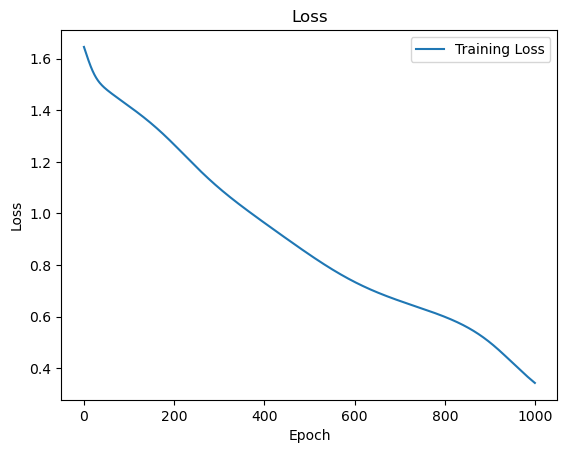

In [367]:
mlp.loss_plot()

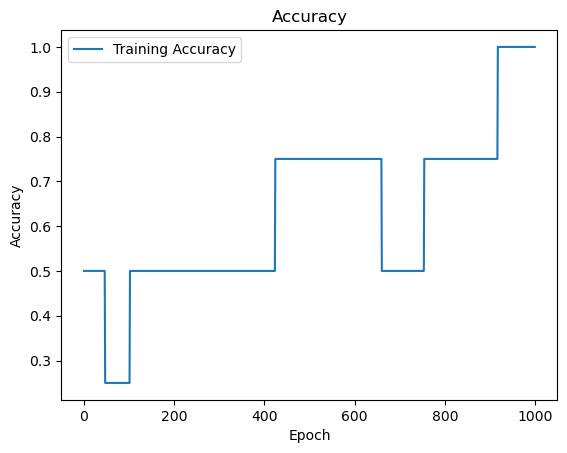

In [368]:
mlp.accuracy_plot()

In [369]:
np.round(mlp.predict(X))

array([[0.],
       [1.],
       [1.],
       [0.]])